<a href="https://colab.research.google.com/github/jeon-maker/Crowd_counting/blob/main/use_2ndmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 InceptionResNetV2 mode 사용

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
import tensorflow as tf
import keras

print('Python version : ', sys.version)
print('TensorFlow version : ', tf.__version__)
print('Keras version : ', keras.__version__)

Python version :  3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
TensorFlow version :  2.8.0
Keras version :  2.8.0


In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Mymodel/model.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 55,124,193
Trainable params: 787,457
Non-trainable params: 54,336,736
_________________________________________________________________


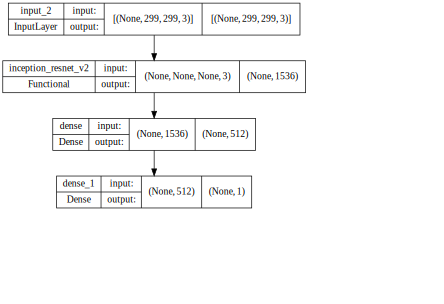

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True,dpi=50).create(prog='dot', format='svg'))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

모델에 필요한 함수 부분

In [ ]:
import time
import concurrent.futures
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import PIL
from PIL.ImageDraw import Draw

In [ ]:
def reconstruct_path(image_id: int) -> str:
    """Function transforms numerical image ID
    into a relative file path filling in leading zeros
    and adding file extension and directory.
    :param image_id: Image ID
    :return: Relative path to the image
    """
    image_id = str(image_id).rjust(6, '0')
    return f'/content/drive/MyDrive/crowd_detection/frames/frames/seq_{image_id}.jpg'

def detect_objects(path: str, model) -> dict:
    """Function extracts image from a file, adds new axis
    and passes the image through object detection model.
    :param path: File path
    :param model: Object detection model
    :return: Model output dictionary
    """
    image_tensor = tf.image.decode_jpeg(
        tf.io.read_file(path), channels=3)[tf.newaxis, ...]
    return model(image_tensor)

def count_persons(path: str, model, threshold=0.) -> int:
    """Function counts the number of persons in an image
    processing "detection_classes" output of the model
    and taking into account confidence threshold.
    :param path: File path
    :param model: Object detection model
    :param threshold: Threshold for confidence scores
    :return: Number of people for one image
    """
    results = detect_objects(path, model)
    # Class ID 1 = "person"
    return (results['detection_classes'].numpy()[0] == 1)[np.where(
        results['detection_scores'].numpy()[0] > threshold)].sum()

def draw_bboxes(image_path, data: dict, threshold=0.) -> PIL.Image:
    """Function displays an image with bounding boxes
    overlaid for every detected person.
    :param image_path: File path to an image
    :param data: Output of objects detection model for this image
    :param threshold: Threshold for confidence scores
    :return: PIL.Image object
    """
    image = PIL.Image.open(image_path)
    draw = Draw(image)

    im_width, im_height = image.size
    boxes = data['detection_boxes'].numpy()[0]
    classes = data['detection_classes'].numpy()[0]
    scores = data['detection_scores'].numpy()[0]

    for i in range(int(data['num_detections'][0])):
        if classes[i] == 1 and scores[i] > threshold:
            ymin, xmin, ymax, xmax = boxes[i]
            (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                          ymin * im_height, ymax * im_height)
            draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
                      width=4, fill='red')

    return image

def set_display():
    """Function sets display options for charts and pd.DataFrames.
    """
    # Plots display settings
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 12, 8
    plt.rcParams.update({'font.size': 14})
    # DataFrame display settings
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.options.display.float_format = '{:.4f}'.format

In [ ]:
# TensorFlow settings and training parameters
AUTOTUNE = tf.data.experimental.AUTOTUNE
EPOCHS = 100
BATCH_SIZE = 16
PATIENCE = 10
LEARNING_RATE = 1e-3
IMAGE_SIZE = 299

In [ ]:
def load_image(is_labelled: bool, is_training=True):
    """Wrapper function that returns a function
    for loading a single image if is_labelled=False
    or a function for loading image in an image-label pair
    if is_labelled=True.
    :param is_labelled: Boolean argument defining the return
    :param is_training: Boolean argument for image augmentation
    :return: Function
    """
    def _get_image(path: str) -> tf.Tensor:
        """Function loads image from a file.
        :param path: Path to image file
        :return: Tensor with preprocessed image
        """
        image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
        image = tf.cast(image, dtype=tf.int32)
        image = tf.image.resize_with_pad(image, IMAGE_SIZE, IMAGE_SIZE)
        if is_training:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, 0.1)
            image = tf.image.random_contrast(image, 0.1, 0.2)
            image = tf.image.random_saturation(image, 0.9, 1.1)
            image = tf.image.random_hue(image, 0.1)
        return tf.keras.applications.inception_resnet_v2.preprocess_input(image)

    def _get_image_label(img: tf.Tensor, label: int) -> tuple:
        """Function loads the image in an image-label pair.
        :param img: Tensor with original image
        :param label: Target value
        :return: Tuple with TF tensor and label
        """
        return _get_image(img), label

    return _get_image_label if is_labelled else _get_image
def prepare_dataset(dataset, is_training=True, is_labeled=True):
    """Function transforms a TF dataset containing file paths
    or file paths and labels to a dataset with image tensors and labels.
    :param dataset: Original dataset
    :param is_training: Argument defines if shuffling and image augmentation should be applied
    :param is_labeled: Argument defines if the dataset contains labels
    :return: Updated dataset
    """
    image_read_fn = load_image(is_labeled, is_training)
    dataset = dataset.map(image_read_fn, num_parallel_calls=AUTOTUNE)
    return dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

def create_model() -> tf.keras.Model:
    """Function initializes and compiles a regression model
    with pretrained feature extractor.
    :return: TF Model object
    """
    feature_model = tf.keras.applications.InceptionResNetV2(
        include_top=False, pooling='avg')
    feature_model.trainable = False

    model = tf.keras.Sequential([
        tf.keras.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        feature_model,
        tf.keras.layers.Dense(512, activation='selu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model

def plot_history(hist):
    """Function plots a chart with training and validation metrics.
    :param hist: Tensorflow history object from model.fit()
    """
    mae = hist.history['mean_absolute_error']
    val_mae = hist.history['val_mean_absolute_error']
    x_axis = range(1, len(mae) + 1)
    plt.plot(x_axis, mae, 'bo', label='Training')
    plt.plot(x_axis, val_mae, 'ro', label='Validation')
    plt.title('MAE')
    plt.legend()
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.show()

def set_seed(seed=42):
    """Utility function to use for reproducibility.
    :param seed: Random seed
    :return: None
    """
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/crowd_detection/labels.csv")

In [ ]:
data['path'] = data['id'].apply(reconstruct_path)


In [ ]:
# Create train and validation data sets.
data_train = data.head(1700)
data_valid = data.tail(300)

ds_train = tf.data.Dataset.from_tensor_slices((data_train['path'], data_train['count'])) #이미지와 실제 카운트를 훈련시킴
ds_valid = tf.data.Dataset.from_tensor_slices((data_valid['path'], data_valid['count'])) #검증모델

ds_train = prepare_dataset(ds_train)
ds_valid = prepare_dataset(ds_valid, is_training=False)

새로운 평가 데이터 만들기 위해서 데이터 구조 살펴보기

In [ ]:
data_train

,id,count,path
0,1,35,/content/drive/MyDrive/crowd_detection/frames/...
1,2,41,/content/drive/MyDrive/crowd_detection/frames/...
2,3,41,/content/drive/MyDrive/crowd_detection/frames/...
3,4,44,/content/drive/MyDrive/crowd_detection/frames/...
4,5,41,/content/drive/MyDrive/crowd_detection/frames/...
...,...,...,...
1695,1696,35,/content/drive/MyDrive/crowd_detection/frames/...
1696,1697,31,/content/drive/MyDrive/crowd_detection/frames/...
1697,1698,29,/content/drive/MyDrive/crowd_detection/frames/...
1698,1699,28,/content/drive/MyDrive/crowd_detection/frames/...


In [ ]:
new_test_data = pd.DataFrame([{"id":1,"count":9,"path":"/content/drive/MyDrive/crowd_detection/six.jpg"},
                              {"id":2,"count":29,"path":"/content/drive/MyDrive/crowd_detection/tot_.jpg"},
                              {"id":3,"count":29,"path":"/content/drive/MyDrive/crowd_detection/29.jpg"},
                              {"id":4,"count":18,"path":"/content/drive/MyDrive/crowd_detection/class18.jpg"},
                              {"id":5,"count":11,"path":"/content/drive/MyDrive/crowd_detection/ssu11.jpg"},
                              {"id":6,"count":10,"path":"/content/drive/MyDrive/crowd_detection/10people.jpg"},
                              {"id":7,"count":10,"path":"/content/drive/MyDrive/crowd_detection/10people2.jpg"},
                              {"id":8,"count":10,"path":"/content/drive/MyDrive/crowd_detection/10people3.jpg"},
                              {"id":9,"count":11,"path":"/content/drive/MyDrive/crowd_detection/11microsoft.jpg"}])

In [ ]:
new_test_data

,id,count,path
0,1,9,/content/drive/MyDrive/crowd_detection/six.jpg
1,2,29,/content/drive/MyDrive/crowd_detection/tot_.jpg
2,3,29,/content/drive/MyDrive/crowd_detection/29.jpg


In [ ]:
new_valid = tf.data.Dataset.from_tensor_slices((new_test_data['path'], new_test_data['count'])) #검증모델
new_valid = prepare_dataset(new_valid, is_training=False)

In [ ]:
new_valid

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
new_pred = model.predict(new_valid) #모델을 통한 검증데이터 예측값을 pred에 넣었음.

In [ ]:
new_pred = np.around(new_pred)

In [ ]:
new_test_data['pred'] = new_pred
new_test_data['miss'] = abs(new_test_data['pred']-new_test_data['count'])

In [ ]:
new_test_data

,id,count,path,pred,miss
0,1,9,/content/drive/MyDrive/crowd_detection/six.jpg,16.0,7.0
1,2,29,/content/drive/MyDrive/crowd_detection/tot_.jpg,39.0,10.0
2,3,29,/content/drive/MyDrive/crowd_detection/29.jpg,41.0,12.0


In [ ]:
mse, mae = model.evaluate(ds_valid)
print(f'Validation MSE = {mse}\n'
      f'Validation MAE = {mae}')

19/19 [==============================] - 151s 6s/step - loss: 16.6413 - mean_absolute_error: 3.1887
Validation MSE = 16.641332626342773
Validation MAE = 3.1886982917785645


In [ ]:
example_path = '/content/drive/MyDrive/crowd_detection/frames/frames/seq_000010.jpg'


In [ ]:
model

사진으로 평가하기


In [ ]:
example_path

'/content/drive/MyDrive/crowd_detection/frames/frames/seq_000010.jpg'

In [ ]:
def detect_objects2(path: str, model) -> dict:
    """Function extracts image from a file, adds new axis
    and passes the image through object detection model.
    :param path: File path
    :param model: Object detection model
    :return: Model output dictionary
    """
    image = tf.image.decode_jpeg(
        tf.io.read_file(path), channels=3)[None, ...]
    image = tf.cast(image, dtype=tf.int32)
    image = tf.image.resize_with_pad(image,IMAGE_SIZE, IMAGE_SIZE)

    return model(image)

검증에 쓰기 위해서는 사이즈가 none,299,299,3 이어야 하는데
현재 사이즈는 1,480,640,3임 -> detect_object2로 사이즈를 맞춰주려고 함. 
그러나 size가 299, 299, 3 이런식으로 뜸. 4D가 되야 하는데 3D가 나옴
--> 현재 1,299,299,3 임
--> None,299,299,3으로 바꿔야함
바꾸는게 힘들면 예측값만 찾아보기


In [ ]:
results = detect_objects2(example_path, model)
results

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[42.99032]], dtype=float32)>

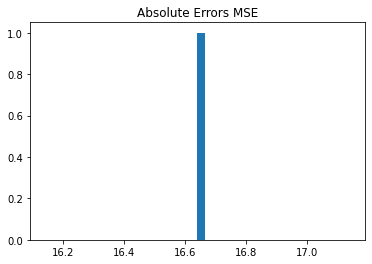

In [ ]:
plt.hist(mse, bins=40)
plt.title('Absolute Errors MSE')
plt.show()

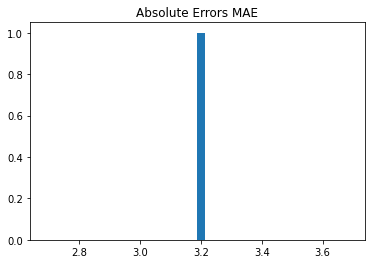

In [ ]:
plt.hist(mae, bins=40)
plt.title('Absolute Errors MAE')
plt.show()

In [ ]:
pred = model.predict(ds_valid) #모델을 통한 검증데이터 예측값을 pred에 넣었음.

In [ ]:
pred.shape

(300, 1)

In [ ]:
pred = np.around(pred)

In [ ]:
pred = pred.astype(int)

In [ ]:
data_valid['pred'] = pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data_valid['miss'] = abs(data_valid['pred']-data_valid['count'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data_valid.head()

,id,count,path,pred,miss
1700,1701,31,/content/drive/MyDrive/crowd_detection/frames/...,29,2
1701,1702,29,/content/drive/MyDrive/crowd_detection/frames/...,32,3
1702,1703,36,/content/drive/MyDrive/crowd_detection/frames/...,36,0
1703,1704,35,/content/drive/MyDrive/crowd_detection/frames/...,33,2
1704,1705,37,/content/drive/MyDrive/crowd_detection/frames/...,33,4


In [ ]:
between20_30 = data_valid[(data_valid['count']>=20) & (data_valid['count']<30)]
between30_40 = data_valid[(data_valid['count']>=30) & (data_valid['count']<40)]
over40 = data_valid[(data_valid['count']>=40)]

In [ ]:
between20_30['miss'].mean()


3.0277777777777777

In [ ]:
between30_40['miss'].mean()


2.433333333333333

In [ ]:
over40['miss'].mean()


6.166666666666667

In [ ]:
(data_valid[data_valid['miss']==13])

,id,count,path,pred,miss
1715,1716,45,/content/drive/MyDrive/crowd_detection/frames/...,32,13
1877,1878,40,/content/drive/MyDrive/crowd_detection/frames/...,27,13


In [ ]:
example_path

'/content/drive/MyDrive/crowd_detection/frames/frames/seq_000010.jpg'

In [ ]:
from PIL import Image
 
image = Image.open('/content/drive/MyDrive/crowd_detection/frames/frames/seq_001716.jpg')
 
image.show()

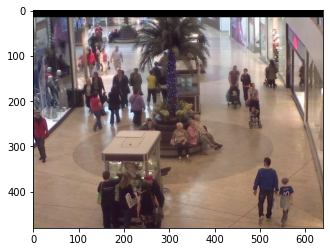

In [ ]:
plt.imshow(image)

In [ ]:
data_valid['miss'].mean()

3.17

In [ ]:
len(data_valid[data_valid['miss']==0])

25

In [ ]:
len(data_valid[data_valid['miss']==1])

69

In [ ]:
len(data_valid[data_valid['miss']==2])

54

In [ ]:
len(data_valid[data_valid['miss']==3])

47

In [ ]:
for i in range(14):
    correct = len(data_valid[data_valid['miss']==i])
    accuracy = (int(correct)/300)*100
    print("miss : %d 의 비율은 %f 퍼센트 입니다" %(i,accuracy))  

miss : 0 의 비율은 8.333333 퍼센트 입니다
miss : 1 의 비율은 23.000000 퍼센트 입니다
miss : 2 의 비율은 18.000000 퍼센트 입니다
miss : 3 의 비율은 15.666667 퍼센트 입니다
miss : 4 의 비율은 9.333333 퍼센트 입니다
miss : 5 의 비율은 8.000000 퍼센트 입니다
miss : 6 의 비율은 7.666667 퍼센트 입니다
miss : 7 의 비율은 4.000000 퍼센트 입니다
miss : 8 의 비율은 1.000000 퍼센트 입니다
miss : 9 의 비율은 1.666667 퍼센트 입니다
miss : 10 의 비율은 1.666667 퍼센트 입니다
miss : 11 의 비율은 0.666667 퍼센트 입니다
miss : 12 의 비율은 0.333333 퍼센트 입니다
miss : 13 의 비율은 0.666667 퍼센트 입니다


In [ ]:
sum = 0
for i in range(6):
    correct = len(data_valid[data_valid['miss']==i])
    accuracy = (int(correct)/300)*100
    sum += accuracy
print(sum)    

82.33333333333333


In [ ]:
ds_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
ds_valid

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
missarr= []
for i in range (300):
  miss=float(pred[i])-float(data_valid['count'][1700+i])
  if(miss < 0):
    miss = -(miss)
  missarr.append(miss)


In [ ]:
missarr

[1.9166584014892578,
 3.1206703186035156,
 0.2544975280761719,
 2.0139389038085938,
 4.484100341796875,
 0.7679386138916016,
 1.3815593719482422,
 0.957366943359375,
 2.7081222534179688,
 4.345634460449219,
 1.7866764068603516,
 7.4839935302734375,
 12.087038040161133,
 11.45677375793457,
 9.63385009765625,
 12.786334991455078,
 9.910514831542969,
 1.1055984497070312,
 4.012786865234375,
 2.2383041381835938,
 4.7698822021484375,
 4.837455749511719,
 8.956737518310547,
 7.3962860107421875,
 5.634696960449219,
 5.7464599609375,
 5.9801177978515625,
 0.5125579833984375,
 3.4407920837402344,
 5.431549072265625,
 5.330127716064453,
 4.116786956787109,
 3.4433822631835938,
 1.5956802368164062,
 1.6039047241210938,
 1.3616371154785156,
 6.111356735229492,
 1.9412956237792969,
 6.081230163574219,
 1.3770904541015625,
 4.295007705688477,
 7.461786270141602,
 1.1305065155029297,
 1.8226680755615234,
 0.08849906921386719,
 3.3912715911865234,
 1.8953971862792969,
 0.5342464447021484,
 2.913928985

In [ ]:
aver = np.mean(missarr)

In [ ]:
aver

3.1886982345581054